In [346]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy.linalg import norm as npnorm

In [347]:
reg_lambda = 0.0 # regularization coefficients attempted: [0, 0.05, 0.1]
percent_sup_trained_on = 0.01 # "hint" training percentages attempted: [0.01, 0.05, 0.1]

In [348]:
image_data = pd.read_csv("recoded_HAR_images_DEC3.csv")
calling_set = image_data[image_data["target"].str.contains("calling")] # get calling action
calling_and_other_set = image_data[image_data["target"].str.contains("calling|sitting|running")] # get calling, sitting, and running actions

# get data to train supervised model on
sup_s = np.asarray(calling_and_other_set.drop('target', axis=1))
sup_y = np.array([{'calling': 1, 'sitting': 0, 'running': 0}[item] for item in calling_and_other_set["target"]]) # recode calling to 1 and other actions to 0
sup_s, remaining_s, sup_y, remaining_y = train_test_split(sup_s, sup_y, train_size=percent_sup_trained_on, random_state=42) # train supervised model on small portion of data
sup_s_train, sup_s_test, sup_y_train, sup_y_test = train_test_split(sup_s, sup_y, test_size=.2, random_state=42) # split data alloted to train supervised model into train and test sets

# get data to train unsupervised model on
unsup_s = np.asarray(calling_set.drop("target", axis=1)) # the target column is not needed for unsupervised learning
unsup_s_train, unsup_s_test = train_test_split(unsup_s, test_size=.2, random_state=42) # split into train and test sets

In [350]:
# get all data to test on, including similar and dissimilar actions of texting and sleeping
image_data_s = np.asarray(image_data.drop("target", axis=1))
image_data_y = np.asarray([{'calling': 1,'texting':0, 'sleeping':0, 'sitting': 0, 'running': 0}[item] for item in image_data["target"]]) # recode calling to 1 and other actions to 0
image_data_labels = np.asarray(image_data['target']) # get string labels for plotting and differntiating between non-calling actions

In [352]:
# Module 1
def phi(si, theta):
    return np.dot(np.append(si, 1), theta)
def ydotdot(si, theta):
    return 1/(1 + np.exp(-phi(si, theta)))
def ci(si, theta, yi):
    return -yi*np.log(ydotdot(si, theta)) - (1-yi)*np.log(1-ydotdot(si, theta))
def ln(s, theta, y, reg_lambda):
    sumci = 0
    for i in range(len(y)):
        sumci += ci(s[i], theta, y[i])
    return sumci/len(y) + reg_lambda*(npnorm(theta, ord=2)^2)

# Module 2
# dln/dtheta = d(sum(ci)/n + lambda*|theta|^2)/dtheta = (1/n)sum(dci/dtheta) + lambda*2*theta
def gradci(si, theta, yi):
    return -(yi - ydotdot(si, theta))*np.append(si, 1)
def dlndtheta(s, theta, y, reg_lambda):
    sumci = 0
    for i in range(len(y)):
        sumci += gradci(s[i], theta, y[i])
    return sumci/len(y) + reg_lambda*2*theta

# Module 3
def gradientdescent(s, theta, y, reg_lambda=.01, gamma=.01, max_iter=10000):
    gradnorm_history = np.nan
    gradnorm = np.Inf
    for t in range(max_iter):
        if gradnorm < 10e-4: return theta, gradnorm_history
        dln = dlndtheta(s, theta, y, reg_lambda)
        theta = np.subtract(theta, gamma*dln)
        gradnorm = np.max(np.abs(dln))
        print("Iterations: "+str(t)+" \t gradnorm = "+str(gradnorm))
        if not isinstance(gradnorm_history, np.ndarray): gradnorm_history = np.array([[t, gradnorm]])
        else: gradnorm_history = np.vstack([gradnorm_history, [t, gradnorm]])
    return theta, gradnorm_history

In [353]:
# train supervised model
sup_theta, sup_gradnorm_history = gradientdescent(sup_s_train, np.zeros(sup_s_train.shape[1] + 1), sup_y_train, reg_lambda=reg_lambda)
sup_theta

Iterations: 0 	 gradnorm = 0.3
Iterations: 1 	 gradnorm = 0.2992242788894493
Iterations: 2 	 gradnorm = 0.298450558342838
Iterations: 3 	 gradnorm = 0.29767883687394553
Iterations: 4 	 gradnorm = 0.29690911294348055
Iterations: 5 	 gradnorm = 0.29614138495976244
Iterations: 6 	 gradnorm = 0.2953756512793982
Iterations: 7 	 gradnorm = 0.29461191020795424
Iterations: 8 	 gradnorm = 0.29385016000062586
Iterations: 9 	 gradnorm = 0.29309039886290045
Iterations: 10 	 gradnorm = 0.2923326249512178
Iterations: 11 	 gradnorm = 0.2915768363736258
Iterations: 12 	 gradnorm = 0.2908230311904313
Iterations: 13 	 gradnorm = 0.2900712074148476
Iterations: 14 	 gradnorm = 0.2893213630136367
Iterations: 15 	 gradnorm = 0.2885734959077476
Iterations: 16 	 gradnorm = 0.28782760397295026
Iterations: 17 	 gradnorm = 0.28708368504046505
Iterations: 18 	 gradnorm = 0.2863417368975875
Iterations: 19 	 gradnorm = 0.28560175728830933
Iterations: 20 	 gradnorm = 0.28486374391393426
Iterations: 21 	 gradnorm = 0

array([ 0.05157078, -0.16670284, -0.26003463, -0.27360904, -0.25406766,
       -0.24032728, -0.22998752, -0.23843697, -0.22587178, -0.22939992,
       -0.22388312, -0.22148971, -0.20642742, -0.20453086, -0.20180979,
       -0.19502241, -0.18267145, -0.17406522, -0.17093126, -0.16789613,
       -0.15588417, -0.14882435, -0.14217056, -0.1557085 , -0.14777098,
       -0.15242055, -0.14849776, -0.14449017, -0.15142724, -0.14474736,
       -1.22242775])

In [354]:
# train unsupervised model with theats initialized with trained thetas from supervised model
unsup_theta, unsup_gradnorm_history = gradientdescent(unsup_s_train, sup_theta, np.ones(unsup_s_train.shape[0]), reg_lambda=reg_lambda)
unsup_theta

Iterations: 0 	 gradnorm = 0.803014970982437
Iterations: 1 	 gradnorm = 0.8016998584123323
Iterations: 2 	 gradnorm = 0.8003803172809424
Iterations: 3 	 gradnorm = 0.7990563833191795
Iterations: 4 	 gradnorm = 0.7977280927394818
Iterations: 5 	 gradnorm = 0.7963954822306801
Iterations: 6 	 gradnorm = 0.7950585889527094
Iterations: 7 	 gradnorm = 0.7937174505311976
Iterations: 8 	 gradnorm = 0.7923721050519132
Iterations: 9 	 gradnorm = 0.7910225910550851
Iterations: 10 	 gradnorm = 0.7896689475295857
Iterations: 11 	 gradnorm = 0.7883112139069939
Iterations: 12 	 gradnorm = 0.7869494300555195
Iterations: 13 	 gradnorm = 0.7855836362738151
Iterations: 14 	 gradnorm = 0.7842138732846586
Iterations: 15 	 gradnorm = 0.782840182228518
Iterations: 16 	 gradnorm = 0.7814626046570032
Iterations: 17 	 gradnorm = 0.7800811825261922
Iterations: 18 	 gradnorm = 0.7786959581898552
Iterations: 19 	 gradnorm = 0.7773069743925679
Iterations: 20 	 gradnorm = 0.7759142742627043
Iterations: 21 	 gradnorm

array([ 2.45561040e-01,  2.58149616e-02, -6.65363953e-02, -7.99930723e-02,
       -5.95016610e-02, -4.55772174e-02, -3.49073618e-02, -4.36426816e-02,
       -3.10006922e-02, -3.48011078e-02, -2.93675338e-02, -2.72234211e-02,
       -1.21746594e-02, -1.04039288e-02, -7.77752045e-03, -9.59874557e-04,
        1.11390364e-02,  1.95329584e-02,  2.26101022e-02,  2.52270115e-02,
        3.71827417e-02,  4.40504785e-02,  5.05334871e-02,  3.68048968e-02,
        4.45963094e-02,  3.98138589e-02,  4.35458187e-02,  4.73292604e-02,
        4.03418379e-02,  4.67344793e-02,  4.57125186e+00])

In [355]:
# train unsupervised model without "hint", thetas initialized to zero
nohint_unsup_theta, nohint_unsup_gradnorm_history = gradientdescent(unsup_s_train, np.zeros(sup_s_train.shape[1] + 1), np.ones(unsup_s_train.shape[0]), reg_lambda=reg_lambda)
nohint_unsup_theta

Iterations: 0 	 gradnorm = 0.5
Iterations: 1 	 gradnorm = 0.4987084462862945
Iterations: 2 	 gradnorm = 0.4974202461591564
Iterations: 3 	 gradnorm = 0.4961354078609116
Iterations: 4 	 gradnorm = 0.4948539393479751
Iterations: 5 	 gradnorm = 0.4935758482935927
Iterations: 6 	 gradnorm = 0.492301142090601
Iterations: 7 	 gradnorm = 0.4910298278541812
Iterations: 8 	 gradnorm = 0.489761912424636
Iterations: 9 	 gradnorm = 0.4884974023701582
Iterations: 10 	 gradnorm = 0.4872363039896096
Iterations: 11 	 gradnorm = 0.48597862331530756
Iterations: 12 	 gradnorm = 0.48472436611580605
Iterations: 13 	 gradnorm = 0.483473537898689
Iterations: 14 	 gradnorm = 0.4822261439133574
Iterations: 15 	 gradnorm = 0.48098218915382107
Iterations: 16 	 gradnorm = 0.4797416783614903
Iterations: 17 	 gradnorm = 0.478504616027966
Iterations: 18 	 gradnorm = 0.4772710063978283
Iterations: 19 	 gradnorm = 0.4760408534714262
Iterations: 20 	 gradnorm = 0.47481416100766144
Iterations: 21 	 gradnorm = 0.47359093

array([0.14928883, 0.14744192, 0.14794378, 0.14796488, 0.14864528,
       0.14876191, 0.14897469, 0.14872837, 0.14879021, 0.1485619 ,
       0.14847846, 0.14827811, 0.14824441, 0.14814385, 0.14805563,
       0.14806693, 0.14786023, 0.14768556, 0.14763522, 0.14730665,
       0.14725115, 0.14709447, 0.14695867, 0.14680271, 0.14667661,
       0.14657046, 0.14641828, 0.14623693, 0.14619085, 0.14596665,
       4.4552663 ])

In [356]:
# functions for computing accuracy, precision, recall, f1score, etc.
def get_accuracy_metric_components(s, theta, y):
    preds = np.zeros(y.shape[0])
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(y.shape[0]):
        preds[i] = ydotdot(s[i], theta)
        if preds[i] >= .5:
            if y[i] == 1: tp += 1
            else: fp += 1
        else:
            if y[i] == 0: tn += 1
            else: fn += 1
    return preds, tp, tn, fp, fn
def get_accuracy_metrics(s, theta, y):
    preds, tp, tn, fp, fn = get_accuracy_metric_components(s, theta, y)
    print(tp, tn, fp, fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn+10e-10)
    precision = tp/(tp+fp+10e-10)
    recall = tn/(tn+fn+10e-10)
    f1score = 2*(precision*recall)/(precision + recall + 10e-10)
    return accuracy, precision, recall, f1score

# functions for computing clustering metrics based on clusters of 'calling' and 'non-calling
def get_cluster_centroids(s, theta, y):
    preds = np.zeros(y.shape[0])
    non_calling = np.array([])
    calling = np.array([])
    for i in range(y.shape[0]):
        preds[i] = ydotdot(s[i], theta)
        if y[i] == 1:
            calling = np.append(calling, preds[i])
        else:
            non_calling = np.append(non_calling, preds[i])
    return calling, non_calling, np.mean(calling), np.mean(non_calling)
def cluster_sum_of_squares(s, theta, y):
    calling, non_calling, calling_centroid, non_calling_centroid = get_cluster_centroids(s, theta, y)
    calling_wcss = 0
    for point in calling:
        calling_wcss += abs(point - calling_centroid)
    calling_wcss /= len(calling)+10e-10
    non_calling_wcss = 0
    for point in non_calling:
        non_calling_wcss += abs(point - non_calling_centroid)
    non_calling_wcss /= len(non_calling)+10e-10
    avg_wcss = (calling_wcss + non_calling_wcss)/2
    avg_bcss = abs(calling_centroid - non_calling_centroid)/2
    print("wcss for clusters", calling_wcss, non_calling_wcss)
    return avg_wcss, avg_bcss

In [357]:
# print metrics
print("supervised")
print(get_accuracy_metrics(sup_s_train, sup_theta, sup_y_train))
print("test")
print(get_accuracy_metrics(sup_s_test, sup_theta, sup_y_test))
print()
print("unsup hint")
print(get_accuracy_metrics(sup_s_train, unsup_theta, sup_y_train))
print(cluster_sum_of_squares(sup_s_train, unsup_theta, sup_y_train))
print("test")
print(get_accuracy_metrics(image_data_s, unsup_theta, image_data_y))
print(cluster_sum_of_squares(image_data_s, unsup_theta, image_data_y))
print()
print("unsup no hint")
print(get_accuracy_metrics(sup_s_train, nohint_unsup_theta, sup_y_train))
print(cluster_sum_of_squares(sup_s_train, nohint_unsup_theta, sup_y_train))
print("test")
print(get_accuracy_metrics(image_data_s, nohint_unsup_theta, image_data_y))
print(cluster_sum_of_squares(image_data_s, nohint_unsup_theta, image_data_y))

supervised
0 16 0 4
(0.79999999996, 0.0, 0.79999999996, 0.0)
test
0 2 0 3
(0.39999999992, 0.0, 0.39999999992, 0.0)

unsup hint
4 0 16 0
(0.19999999999, 0.19999999999, 0.0, 0.0)
wcss for clusters 1.6179112170840767e-05 2.564694588238348e-05
(2.0913029026612122e-05, 1.876614495238682e-05)
test
840 0 3360 0
(0.19999999999995235, 0.19999999999995235, 0.0, 0.0)
wcss for clusters 2.356436790911583e-05 2.4536727003287435e-05
(2.4050547456201633e-05, 3.6224056193523424e-07)

unsup no hint
4 0 16 0
(0.19999999999, 0.19999999999, 0.0, 0.0)
wcss for clusters 0.0003297407494907689 0.00030193629923105507
(0.000315838524360912, 0.00020917735555192607)
test
840 0 3360 0
(0.19999999999995235, 0.19999999999995235, 0.0, 0.0)
wcss for clusters 0.00028475053698811555 0.00028365870126884155
(0.00028420461912847855, 9.376937420979559e-07)


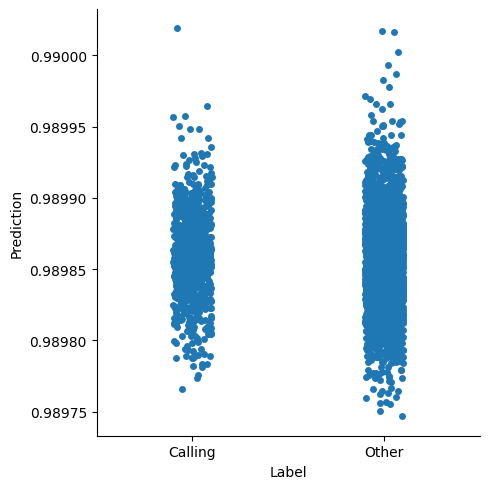

In [358]:
import seaborn as sns

# set up datframe for graphing clusters
calling, non_calling, c_c, nc_c = get_cluster_centroids(image_data_s, unsup_theta, image_data_y)
calling_df = pd.DataFrame(data=calling, columns=["Prediction"])
calling_df['Label'] = "Calling"
non_calling_df = pd.DataFrame(data=non_calling, columns=["Prediction"])
non_calling_df['Label'] = "Other"
cluster_df = pd.concat([calling_df, non_calling_df])

sns.catplot(cluster_df, x="Label", y="Prediction") # graph of clusters

<AxesSubplot: >

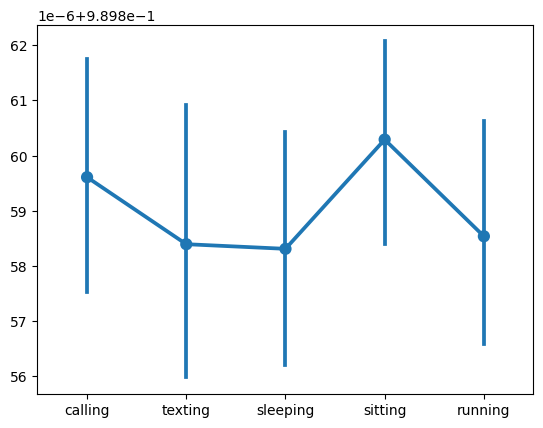

In [359]:
preds, tp, tn, fp, fn = get_accuracy_metric_components(image_data_s, unsup_theta, image_data_y)
sns.pointplot(x=image_data_labels, y=preds) # graph of summed predictions for each action

<AxesSubplot: xlabel='Iteration', ylabel='Gradnorm'>

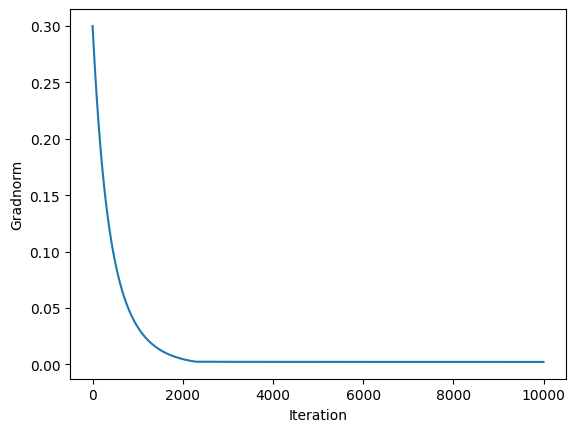

In [360]:
sup_hist_df = pd.DataFrame(sup_gradnorm_history, columns=['Iteration', 'Gradnorm'])
sns.lineplot(sup_hist_df, x="Iteration", y="Gradnorm") # gradient history of supervised model

<AxesSubplot: xlabel='Iteration', ylabel='Gradnorm'>

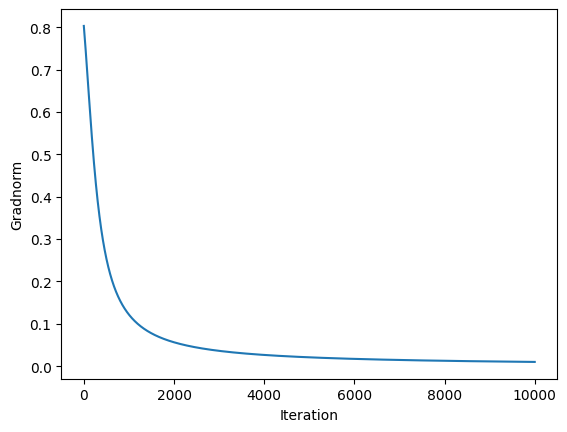

In [361]:
unsup_hist_df = pd.DataFrame(unsup_gradnorm_history, columns=['Iteration', 'Gradnorm'])
sns.lineplot(unsup_hist_df, x="Iteration", y="Gradnorm") # gradient history of unsupervised model with hint

<AxesSubplot: xlabel='Iteration', ylabel='Gradnorm'>

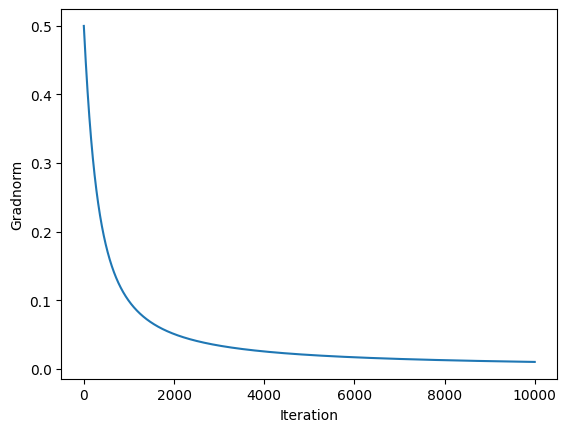

In [362]:
nohint_unsup_hist_df = pd.DataFrame(nohint_unsup_gradnorm_history, columns=['Iteration', 'Gradnorm'])
sns.lineplot(nohint_unsup_hist_df, x="Iteration", y="Gradnorm") # gradient history of unsupervised model without hint

<AxesSubplot: xlabel='Iteration', ylabel='Gradnorm'>

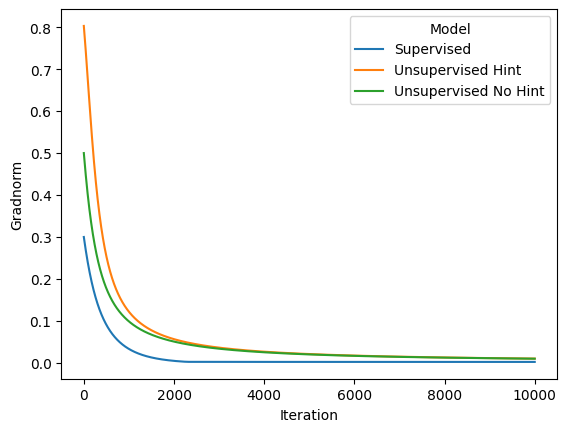

In [363]:
sup_hist_df['Model'] = "Supervised"
unsup_hist_df['Model'] = "Unsupervised Hint"
nohint_unsup_hist_df['Model'] = "Unsupervised No Hint"
hist_df = pd.concat([sup_hist_df, unsup_hist_df, nohint_unsup_hist_df])
sns.lineplot(data=hist_df, x="Iteration", y="Gradnorm", hue="Model") # gradient history of all models

In [364]:
# save data for plotting in R
preds_vs_labels = pd.DataFrame({'Prediction':preds, 'Action':image_data_labels})
preds_vs_labels.to_csv("preds_vs_labels.csv")

hist_df.to_csv("gradnorm_history.csv")